One of my favorite things things about the past week or so is watching the WSJ newsroom argue with the WSJ editorial board about the role of wind in the recent generation crisis in Texas. Both sides are making arguments that make a lot of sense in isolation, but the problem is pulling together the disaparate factoids about wind and gas into a single, coherent narrative.

It's the weekend and the power is back on, so I decided to do a quick data exploration of ERCOT's actual generation over the past few weeks to see if we could answer the question, "Was wind to blame?". Luckily, the EIA keeps up-to-the-minute data (ERCOT releases it on monthly intervals).

The answer, for reasons explained below, is "Not really, but that's not exactly to wind's credit."

A little bit about me: I was an electric utilies lawyer (though it's been a few years) and I am a data scientist (though not a very good one), so there's some expertise on display here but mostly just mashing data together into charts and trying to interpret them.

I included my code so people could check my work (I didn't bother to make it pretty let alone comply with PEP-8, it's for reproducibility not for reference. I tried to front-load it so you can just scroll past it and focus on the graphs and commentary.

In [1]:
import zipfile
import tempfile
import json
import re
from datetime import date

import requests
import pandas as pd
import seaborn as sns
from dateutil.parser import parse
import matplotlib.pyplot as plt

sns.set()

In [2]:
url = 'http://api.eia.gov/bulk/EBA.zip'
with tempfile.NamedTemporaryFile() as f:
  f.write(requests.get(url).content)
  data = zipfile.ZipFile(f).open('EBA.txt').readlines()


In [3]:
ercot_data = []
for d in data:
  if 'ERCO' in d.decode():
    j = json.loads(d)
    if 'ERCO' in j['name']:
      ercot_data.append(j)
  
# filter out duplicated UTC
ercot_data = [d for d in ercot_data if 'local time' in d['name']]
ercot_data = {d['name']: d for d in ercot_data}

In [4]:
list(ercot_data.keys())

['Demand for Electric Reliability Council of Texas, Inc. (ERCO), hourly - local time',
 'Actual Net Interchange for Electric Reliability Council of Texas, Inc. (ERCO) to Centro Nacional de Control de Energia (CEN), hourly - local time',
 'Actual Net Interchange for Electric Reliability Council of Texas, Inc. (ERCO) to Southwest Power Pool (SWPP), hourly - local time',
 'Actual Net Interchange for Southwest Power Pool (SWPP) to Electric Reliability Council of Texas, Inc. (ERCO), hourly - local time',
 'Demand for Electric Reliability Council of Texas, Inc. (ERCO), South Central, hourly - local time',
 'Demand for Electric Reliability Council of Texas, Inc. (ERCO), South, hourly - local time',
 'Demand for Electric Reliability Council of Texas, Inc. (ERCO), West, hourly - local time',
 'Demand for Electric Reliability Council of Texas, Inc. (ERCO), Coast, hourly - local time',
 'Demand for Electric Reliability Council of Texas, Inc. (ERCO), East, hourly - local time',
 'Demand for Electr

In [5]:
gen_data = {re.search(r'Net generation from (.*) for Electric Reliability', k).group(1): v for k, v in ercot_data.items() if 'Net generation from' in k}

In [6]:
df = pd.DataFrame({
    'Time': pd.DataFrame(gen_data['coal']['data'])[0].map(lambda x: parse(x.split('-')[0])),
    'Coal': pd.DataFrame(gen_data['coal']['data'])[1],
    'Nuclear': pd.DataFrame(gen_data['nuclear']['data'])[1],
    'Other': pd.DataFrame(gen_data['solar']['data'])[1] + pd.DataFrame(gen_data['other']['data'])[1],
    'Natural Gas': pd.DataFrame(gen_data['natural gas']['data'])[1],
    'Wind': pd.DataFrame(gen_data['wind']['data'])[1],
}).set_index('Time')

In [7]:
subset = df[df.index.map(lambda x: x.date()) >= date(2021, 1, 1)].sort_index()

In [8]:
# ERCOT's outage data is stored for the past 30 days, and it's stored in a very
# annoying way. So rather than hammering their servers each time to collect the
# outage data, I just stored it in this notebook. The code for reproducing
# the data is in this cell.

# import io
# import re
# from datetime import datetime, date
# from multiprocessing.dummy import Pool

# import bs4
# import pandas as pd
# import requests


# url = 'http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13103&' \
#       'reportTitle=Hourly%20Resource%20Outage%20Capacity&showHTMLView=&mimicKey'
# r = requests.get(url)
# soup = bs4.BeautifulSoup(r.text)

# csv_urls = ['http://mis.ercot.com/' + td.parent.find('a')['href'] 
#             for td in soup.findAll('td', text=re.compile('.*csv.zip'))]

# pool = Pool(5)

# data = []

# for idx, r in enumerate(pool.imap(requests.get, csv_urls)):
#     data.append(dict(pd.read_csv(io.BytesIO(r.content), compression='zip').iloc[0]))

# outages = pd.DataFrame(data)
# outages['Date'] = outages['Date'].map(parse)
# outages['Hour'] = outages['HourEnding'].map(int) - 1
# outages['Time'] = outages.apply(lambda r: datetime(year=r['Date'].year, month=r['Date'].month, day=r['Date'].day,
#                                                    hour=r['Hour']), axis=1)
# outages.rename(columns={'TotalIRRMW': 'Renewable Outages',
#                         'TotalResourceMW': 'Thermal Outages'}, inplace=True)
# outages = outages[outages['Time'].map(lambda x: x.date()) >= date(2021, 1, 1)][['Time', 'Renewable Outages', 'Thermal Outages']].rename(columns={
#     'Time': 'Date',
# }).set_index('Date')

# outages.plot(xlabel='Time', ylabel='MW', color=['#823200', '#53065C']);

import io
import zipfile

# zip bytes
raw_outage_data = b'PK\x03\x04\x14\x00\x08\x00\x08\x00NuTR\x00\x00\x00\x00\x00\x00\x00\x00\xf5\\\x00\x00\x11\x00 \x00ERCOT_outages.csvUT\r\x00\x074t1`4t1`4t1`ux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00}\x9cK\x8e.9n\x85\xe7^E-\xe0\x16@\xea-\x8f=7`x\x03e\xe0\xc2\x1e\xb4=\xb0\xdb\xf0\xf6M*2\xc5s\xe2W\xaa\xd0H\xa0\xfa+=\x82<AQ\xa2\xe2\xff\xa7\xbf\xfe\xfe\xfb\xd7\xbf\xfc\xfe\xaf\xdf\xff\xf7\xd7\xbf\xfd\xed\xf7\x1f\xff\xfc\xbf\x7f\xff\xeb\xdf\x7f\xff\xcf\xaf\x7f\xfd\x8f\xdf\xff\xfd\x9f\x7f\xfd\xed\xfb\xdf\xff!I\xd2?%\xfd\x99\xe4\x0f-\xff(b\xff\xfb\xd5\xa7\xce_)\xa7\\\x08\xe7o\xdcFu\xdc\x85p\xda\xb87\xc3\xbdw\xc2\xfa\x85\xa7\xcaj\xad\x8ce\xe3"\x9fX\xe6\xc6\xcd\xb0\xa6Z\t\x0f\xc22g"\xdc7N\x8eSj\x84\xdb7NE\rkg\\\x03\x9bYD\x1a\xe3o\xab\xcdR\xca\x01\xe7\x8d\xabw.\xcaSK\x8c5\xf3\x83i\xe0|\xc0\xdbjc\xcc_:\xf3\x8c\xb1u\xfe\x91\xf6\xd8\xbde\xc7\xe0P\xc7\xdfc\xabdu\xbb\xb4\xc2\\7\x9f#\xf9\xdc;w\xff=\xba\xda\x7fP\xad\xff>3r\x9d\x9b\xb7\xa6\xce\xf3 >6\xcf\xcbt\x9a\x94x\xdf\xfc\x19\xbf$\xee\xff\xdbo\x9ae\xf8\xfck\x12\xe2\xdf\x8e3I=\xc6M\x95x\xd9\xbc\x95\xf5|\xb3\x13\xff6\x9fV\xa9\xf6w\xce\xc1\xedS\xf0\xe1\xcf\xdf\xe6$\xbe\xed\xd7\xa4v\x9f\xbf\xf2\xfc\xb6\xfd\xeal}\xe9\x92\xec\xb3E\xaf-\xa9\xdbgd\xb2\xcfV\xbd\xf1\xeao\x85\x8dC\xbc\x07\xf77\xd6\xc4O\xfe\xdd\xba\xb7vc8\xef\xf4\xfc[\xf8\xd6~\xfa\xf83\'\xe2\xdb~&\x9c\xe1\xf3\x1f<\xbfm\xbfV\xdd\xbe\xe6e\xd2\xcf\xd6\xbe\xf1^\x0f<\xec\xd7\xd5\xfbo\x93\xfb\xdf\xf6kyv\xd7W\x01\xfb\x8d\x90\xbf=\x9f\xe9\xeb\xe5\x9f\x01\xfao\xa3g\xb7\x9f\x16\xe2\xfa\xe2\x15\xe77@\xff\xcdf\xf6+%\x1d\xc4C\xffmx\xdcI6M\xe2\xe1\xbf\xea\xfeO\xf6\x16\x13\xdf\xfe\xeb+ne\x11!\xbe\xfd\xd7s2\xfb\xe6\xdcx\xfc\xed\xbf>G\xf7\x90\\\x99o\xff\xf5a\xf1!e\xf3\x02\xf1\x1c\xed\x93\xb7\x1f\x99y\x8a\xf9\x89\x85\xfc*\xc2\\\xa3\xffl\xbc\xf4\xc4\xe3K\xf0b\xfe/\xa5e\xe4\xa1\xff!\xdd\xc6/\xa2J|\x04\xf7\xf9\x15\x0b\x82\xc4\xb7\xfd\x86\xbd\xbb\xc6k!\xff\x86\xfe\xad\xa1\xe9\xab\xe4\xca\xed+\xf3\\3\xf9\'\xf4?\xa6\xcf?W\x88\xed\xces\x8c\x9f|A\xcd\x9d\xfbO1\x7fM\xcb?\xe4\xdf\xd0\xff\xb0\x00\xe0\xf3{\xd9G\x80\xfb\x92[\x1b\x8c\xdfA\xff\xbd\x8b\xb5\xd7\x81\xf1\xaf\x83\xfe\xa7)\xcb\xfc7q\xf9\xe8\xa0\xffQ\xd4\xecko9\xb7\x8f\xf1\x8b\xfb\xbf\xf5J<\xf4?\xaa\x1a\xefR\xa8\xff\xd0\xbf\t\xcb\xf4g^V\xe2\xe1\xbf\xde\x17\xcf\xf4|\xa1\xff!\x1e_\xcc\xcb\xdc>\xfcW\x93\xb5\x9f5u\xe2\xe1\xbfb\x0b\x7f\x96T\x07\xf1\xf0_\xf7\xf7o\xd4"\xc4C\xff\xadtkO\xfa\xec\xa0\xff\xd9r\xf9\x95\xb5\xbe\xfa\xdf\xf6\x9b\xe6\x1a\xe3]2\xf2\xd0\xff\xec\xb6\xbey\xffd\xbf\xd0\xff\x17\xaf\x85\x9e/\xf4?-\x010>\xd8?\xa1\x7f\x8b\x9c6\xbe\xf4\xca\xedk\xcc\xbf\x8f\xd5?\xd9?\xf4o\xf27}\xcc\x89\xefO\x07\xfd\xcf\xb6\xeck\xcb8\xf1\xd0\x9f\xbd\x19n\x7f\\\x9f:\xe8\xffio\xeb\x13\xf7\x1f\xf6\xeb\x96_\xa41\xf0\xfdi\xa0\x7f\xf3\xbc\xbd\x7f\x16~\x98\x7f\x8fo+\x7f\xf6\xf9\x8d\x17\x8f\xf1G^\xf6\xc5\xfc\xa6\x81\xfe\xa7%\xbb6\xbf&\x8a\\\xc1\x7f\xa9\xb8}q}i\xa0\x7fk_\x8d\xcf\xc1\xed\xc3\x7fc=\xff\xd0J<\xf4\xaf\xcb\xff\xa3\xd1\xfc@\xff]\xdd\xffm\xf0\xf8\x11\xff=?4\xff\xbcx\xc4\x8f\xe4\xf6\x1b\x03\xf3\xbf\x86\xfa\xaf\xb2\xfc\x8f\xeb[\x0b\xfd{R\xec\xfd\xe7\xcc\xf3\x97\xe0\xfe\xfe\xcf\x89\xfam\xa1\xff$\xd9\x9fO\x8b\x92}\xb6\xfe-sq\xfb\x9a\xfd\xc9\x7f[\xff\xb6\xb2\xdb\xfah\xfb\x99N\xf3\xdb\xfa7^]\x7f3s\xffu\x8f?\xaa\xdboV\x9e_\x89\xf1s\xf6\xf9\xf5A<o.\xe2\xefOo\xf4\xfc[\xff\xc6\x8b\xcf?)\xcf/\xec7\x97>\xa7\xf0\xf8\x12\xf3\x97\xe2\xf1\x17\xedWC\xff\xd6\xde\xfd\xd7\x06\xe6\x17\x15\xf4\xaf\xbe>x\xfc\x13\xe2{|m\xd3\xfd7\x84\xdb\xc7\xf8m=\x9f\x851\xe4[\xff\xf6\\}\xbd_\x83\xe6\xa7\xe1?Kp\x8c\x97\xa6\xc4\xc3\x7f\xa3\xb9}pK\xe9|\xfb\xcf\x0c\xb8\xec+\xcc\xb7\xffl\xe94\xfb\xd8\xfe\x83\x9eo\xeb?Yjc\xeb\xfb\xa4\xfc\xaa\x86\xfeSZ\xf9Y\x1f\x89\xe7\x17\xf1c$ko\x7f\xb8\xfd\xb6\x9f\xfd\x9f\xae\x9f\x82\xf9a\x05\xfd\x9b\x81\xec\xef,\xa8\x8f\n\xfa\xb7\x0e\xec\xaf-\xaf\xf4|\xa1\x7fk\x9f\xdd\xff#\x13\xef\xf1\xfc\xbe?j\xad\xd0\xf8\xa1\x7f\xb3\xcf\x93_L\xe2\x95\xc7\xf7\x0e\x88\x83\xfe=\x7f\xb1\xfc\x9c\xc7\x0f\xfdu\xdb\xf3[\x16)\xcc\xc3~\xc5\xe2\xa7\xd6\xfcz\xfe\x88\xbf\xb3Z\xfe^&\xeb\x07\xe2\xbf\xa5~\xb6\x0b\x9c\xf8\xfc\x05\xe2\xbfm\x9cl\xff\x99za\x1e\xf9W\xb5\xf7Gs\xc6\xfc\xa0`\xfeS}~Eq\xfd.\x98\xff\xe4j\xcf\x97\xbb\x10\x87\xfcG|\xfc<0\xff.\x10\xff-\xff\xf5\xf1G\x99\xc4#\xffw\xffi\xa9\x83\xe6\x07\xf9\x7fZ\xe3\xcf\xaa\xc4+\xf4\xaf>\xff\xc1\xf3\x8b\xf8\xdf|\x7fk\xeeg\x1e\xf1\xdf60\xd6\xdeVP\xe2\x11\xff\x8b\xad_Z\x8a\x90}!\xff\xb7g\xf3\xf9e\x9e\x9f\xc0\xfc\xbb\xdb\xbf\xd3\xf3E\xfe\xd3k\xb6\xfe\xd3\xe4\xe7\x87\xfd\xaf%\x98\xd6^\xd9\xfe\xb0\xff\xad\xd3\xc7\xcf\x8d\xe6\x0f\xfb\xdfb\xf1\xd1\xe6W\xb8}\xec\x7f\xfbX\xfeS\x1e?\xf6\xbfU}\xfe\xbd\x90\x7fa\xff\xeb\xf9\x8b\xb5O\x85x\xec?\xfb\xd2G\xaf<?}\xf1\xa1\xdc\xbf\xc4\xf3/\xde\xb0\xff\x8c\xfb\xdfQ|~\x05\xe3S\x06\xfd[\xf8w\xfd\xb5\x9e\x89\x87\xff\xd2\xc8\xceq}\xcf\xa0\xff\x9eW\xfb4\xa8}\xe8\xdf\xccg\xdc6\x10\x9d8\xe8?\xfb\xfbI\xfb\xb3\x8c\xfa\xf7\xf5\xc7\xfc\x8f\xf9kF\xfd\xdb\x9b\xbd\xf4\x91\x88\x87\xfe\xeb\xf2\xefP\xee?\xf4o[S?%\xca\xdc\x1e\xce/\xfc\xf9\x8b&\x9e\x7f\x9c\xff\xf8\xf9\x94\xe9\x0b\xdf\x9f\x8c\xe7?\xed\x89/\x8d\xfb\x0f\xff\xd9\x0b\xfe\xd6\x7f\xc6\xf3\x9f\x87\'\x9e?\xe8\xdf\xd7o\xf5\x04\x9e8\x9e\x1f\xb8\xff\x06\xae\xaf\x19\xf4\xdf\xfdL\xd6O\xc9\x1a\xf1\xb0\x9f\x1f\xabj\xc9\x99\xfc\x1b\xfa\xff\x81\xe77\xef\xa4\x1fI/\xae\x85\xec\'\xca\xdc\xde\x1f\xee?\xec7\xfd\xfc\xc76\xa1`\x9fD\xfaW\xb7_\xc1\xf7+\xa1\xfe\xd5\xcf/s\x95I\\\xa1\xff\xb1\xe2K%.\xcc\xd3\xc0\xfds\xc2\xf3\x9f\x87\xb7\xcc<\xf4o\xa9\x97\xafO\x98?%\xd4\xff\xc3[a\x0e\xf1\xab\x88\xb7\xef\xcc#~\xd9\x06\xc0\xf5\x83\xf9]B\xfd{~l\xcf7\xe8\xf9\xf4m?\xa9\xccC\xffc\xad?\xa5p\xffa?\x95\xb4\xc6\xe7\xf6a?m\xc9\x9f\x0f\xf3\xb7\x84\xfa\xcf\x8b\xe7A\xfe\r\xfd\xd7\xd1\xdc\xbeu\x92\xff \xfe\xdb\x06\xc7\xedS\x99\x87\xfd\xda\x8a?3\x91\xfd0\xfeO\x8f_\xa3\xd3\xf3A\xfc\x9f*\x07\x1e\xf6\x9b\xd9\xf5\xdb\'?_\xc4\xff\xd9\xd6\xfa3H\x9f\xa0\x7f\xdb@\xf9\xfa:H?\xa1\xff.\xed\xe1\xd0^Q\xffs\xad\x0f\xb9f\xe2\xa1\xff\xe4\xf3\xab\xadp{\x88\xff~~_m\x16\xc4c\xfc"6\x7f>\xdfS\x8c\xff%\xad\xfeq\x7f\xaf\xa8\xff\xac\xa6\x9f\x9a\x94\xe6\x07\xfa\xcf\xfe\xfeX\xfe3\x89G\xfc\xaa\xbe\xfe\x17A\xff)\xc6\x7f{\x01=\x7f\xa9\xf4|\x18\xff\xbd|\xc2\xe7\xa3\x8a\xf9\x8fm]=\xfe\xf0\xf3\x83\xfe{z\xf4#\xc4\xc3~\x96Z\xae*\x05\xcf/\xec\xa7\xee\xff41\xbfP:\xff_\xfa\x1d\x9dy\xe8\xdf\x94a<\t\xf3\xd0\xbf\xfa\xfb\x9f\xd2\xa0\xf9\xe3\xf9\x7f\x1f\x07\x1e\xfa\x97\xec\xf3S|\x7f\x15\xf4_\xebX\xed\x1b\xf3\xa8\x9fT\xd7\xafm\x13\x99\x87\xfdV\xfee\x01\x82\xfc\x1b\xfa\xaf~~h\x9b\xf8N\xfa\x08\xfd\xd7<\xd7\xfc0~\x0b\xe8\xbfL\x8f?I\xf0\xfcD@\xffe\xcevh\xbf\xc7\xb7\xed\xa3\x1c\xf8\x1e\xdf\x16ny\xc7o\x01\xfd\xe7\xfa\xec?^|\x04\xff\x8a\xef\x89x\x0f\xee\xf9\xa3m\xe3\x85x\x83\xfe\xcb\x81o\xffY\xe4\xec\xde\x7f\xe3\xf1\xb7\xffl\xeb\xb7\xe23\xe6gP\xf0\xb5\xf6+>Ig\xbe\xed\x97d\xe5\xdfX\xdbT(\xf9\xaa-\xec>?:\xff\x84\x9a\xaf\xca\xca_\xde<\x8a\xbe^\xfe\xf1\xf0\xcd\xf8\xdb|\xad.u\xf6\xa2\x84\xbf\xadg/g;\xe0o\xe3\xd5\x15\x1bl\xed\xe0\xce\xbfmW\xba\x87\x86T*IgK\xff\x07\x9c7\x9e\'\x9c\xee\xf8\xdbn\x96p\xfa\xcc3\xa6\xf5P\xf4\xfd\xc6\x105\x04\x8a\xbe\x16\xae\x92\xbf4p\xa8(P\xf4-)u\xc7\x85\xb1\xde\xf1\x1e\xbbv\x8b\x88\x96x\x13\xde\x8a\xb7\x17\xae\xae\x17&\x13\xfe\xf6XMO<\x80\xf7]\xa0\xdekj.\x07\xfc\xed\xb12\xfa\xca\x96:=\xf7V{\xf1\xc3(3K\xe1\xd6\xdbcM\xdd,C\x19o\x8f\xad\xa3\x82\x0f\xfcm\xb5<\xbd\x92\xae\x03\xd4"P\xe9\xcdk\xa1\xf2z\x14a\xd9\xb8\xd4O\xbcu\x9e\xc5\xb7i\x1fx\x1f\xf3L_\xe5\xfd\x98\x87\xf0>\xe5\x99\xeb%z\xe3}\xc8\xf3\xe4@\x8d\xcd\xb2u\x9eS\xae\x07\xfcm\xb5l\xd9\x9dO-\x91C\xb7\xce\xcdh\xf9\xd0:\xdd\xb1\xde\xb1\x04\x967\x86\xea\xee\x83\xa9\xf8-P\xdc\xb5\xac\xdd\x8d:\x85[\xeb\x1d\x0ba\x8f\x8f\x88\xb7\xce\xbfp\x9b\x95\xf0\xd8\xfe\xaek\xdd.\x8c\xc3c\xc5\x97%L\xeb\x04\xca\xbaY\xe6\x93\xf52\xae\xe1\x92\xba\x82\x07\xcd\\\xc3ck\xcf+\x10\xf3\x05j\xba\x86=eO\xc2\x9d\xef#9\xaf\xf8~\xe2m5Y\x1b\x8a\x97\xcdC\xe7\xe2j\xb1\xb1\t\xc7yf\xcfk\xbb\xcef\x01\x9d\xaf\xd5\x0c\xab\x01\x02\xd5\xdc\xf4\x04\xecw\xeb\xc6X*\xb7\xdeg\x99\xd5\x8f\xa2,c(\x84\x0b\xe1\xa4\x83[g\xc6\xf9\xf5`\xdbj\xd5\xf3\xe0\x0f\xacw,\x84\xfd\xb2M`\xa8\xe2\xda\xea\xecIP\x81C\x18\x81"\xee\x83S\x1f\xdc\x1a\xc6\x96\x03\x96+\x8e\x13|/\xa0~\xe2q\xc7\xfd\x8e\xc3c\x1e\xcfM3\x8c\xb7\xc7\xda\x93\\\xbcp\xb9\xe3|\xc7\xe9\x8e\xf5\x8e\xb7\xd5JM\xeb\\\xad \x0e\x9d\x9f\xf1\xb6Z)\xed\x80;\xe3<\x19\xb7;\x8e3\xfb\xb9\x8e\xf4\x12\xcd<t\xfe`\xac8\x0bTlm\xf1\xd7\x03Nw\xacw,\x84S\x83\xd34\x81j\xed\x17\xae\xb0Y\x13,\xd6>\xb8\xc3^R\xa0V\x9b\xf2\xda\xca\xe3U\x15\x81Rm\xca\xbd|\xe2\xd0\xf9\xc2\x16\x1b\x07\xe1\xc1\xb8\r\x9ay\xe8\xfc9\x06-<\xf3\xd0yY\xa7 o\\\x19\xf7L\x0f\x16:_9\xba\tr\x12\xdeV\xcbk-y\x99%t\xee\x150\xdf\x810\xdeV\xf3\x02\xbe\xd9\\\xd9,B\xd8\xb2\x17E\x8c:?\xe1q\xc7\xa1\xf3t\x18\x1bt~\xc4\x95qI\x8c\xcb\x1d\x87\xd5\xb2c,\xac\n\x16f\xcfX\x19+\x1c[\x08\x96e\x0f\x18\xab\xb2imJ\xdf\x98\xc7\xd6\x06{:\xa9\xa4\xf3\x13\x86\xb1\xeb\'\x06\x9d?\x18\n:\x82\x05\xd9\xbc\x12\xd17\xee\x8c\xf1\xb8L\xb0\x1c\x9b\xe7\xda\x13v\xc6\xb1\x02{~\xfe\xd1\x1at~\xea<V\xc1\xb4ZO\xb2\x1a\xe8\xdcO\xe2?0\xac\x82\xed\xd0yX\xad\xa4O\x1c:\x7fpo\x9dp\x94a\xfd\x14\xf4\x03\x7f[\xcd\xef\xbf8V2*\xe6\xe7z\xc0\xdbj}=w\x1b\xe4P\xc8\xcf\xd7\xd8\rv\x92R1??\xe2t\xc7z\xc7B\xd8V\x14\xc8\x15\x0b\xe6\xe7\x0b+\x14\xdf\xa5`~^\x9f46\x11\xd6W\xe7P\x1a\x92\x82\xf9\xf9\x833\x8d\r\xf9y_\x9b\xfbF\x9dG~\xfe`\xbcW"PwM}\x1d\xcb\xd1\x0e\x1a\xca\xaeiU\x95\xd2\x84\xaa\x87\x14\xd4\xb9/\xd0\xa6W\x1e\xbb\x84C=)*\x98\x9fC\xcd5\xf5U\xb2\x13\\$\xa1\xe4\xfa\x8d\xe1DM\xa0\xe2\x9a\xba\x17\xcc>\xb0\\q\xe8|\x1d\xa7S\xb9C\xa0\xdc\xfa\x03\x8e\xfc\xdc\x13Q\xc3\xe4\xb1\xd0\xf9H\'\\\x19g\xf6w\xc4\xf3s\xeb|\xc7\xdbjCOX\xefX.\x18\xaa\xac\x0f\xa6"\x8c@\x91\xf5\x07\xccc\xfbM\x1b\xc2<\xb6\x0e\xd49TX\x7f\xc0\xe3\x85\xa1>#P_\xfd\x01G~\xfe\x9c\x98\xbc\xf0\xde\x87\xfa\xe5\x96O\xbc#\x93\xdf\xed2<xj\x99p\xc6\xab\xf9\x02\xa5U\xeb|\x1c0\xecC}\x93\xab\x9d\xb1\xbc:g\x0c\xe7-\x0b\'\xee|\xeb<\'?X\xf8\xc0\xa1\xf3\xf5\n&\xb8\x14$\x99t^\x0e\xb8\xdeq\xb9\xe3|\xc7\xe9\x8e\xf5\x8e\x85\xb1\xe2\xd9\x1eTS\xd3W1\xac2N\x84\xb3\xe2j\x00\xb5\xd4/\x9c\nc\xb9\xe2\x88\xe7i\x15j\xdfx0~\x8d\xbdu\x9e\xbf\xae)4\x9ay\x9c\xb7\xac\x83$KS+\xe1\xca\xb8\x0e\xee<t>\xd7\x1d\x1b\xb8c$\t\xcf[\xa4\x1fp\xe8|\xdd\xb0yc\xbd\xb7\x16\xc2\xb6\xd9K\x88e\xde\xf1\xb8\xe3\xfe\xc6\x9d\xf0\xb6ZZ\xaf`\x1ed58W<\xe2r\xc7\xf9\x85k!\x9c\xee8\xac\xb6\x8e\xa1\xdeX\x18+\xdc\x1a\x10\xa8\x9a\xa6\xf9\x9c3\xc1\xa5^Q\xcc[\xca\xba\x93\x84\'\x83\x8ay\xcb\x11\xcb\x15\x87\xceEOx\xdcqd\x9a^n\xb5\xa0\xc9x{,\xaf\x93\x837\xde\x1e+I\x0fx{,\x7fEd\xc69Z\xcf\x03N\xd1\xfa\x84\xe3\xfc<\x9f\xc6\x16\xc2\xfe\xa1\x0cb\xd0\xb9\x07.\xdb\xdb0\x8e\xe8\xb0Nc+T\xc1\x05\xaa\xa4y]\xf2\xb1\x15\x98[o\xab\xd5Z\x0e\xb8\xbe\xb02.w\x9c\xef8\xdd\xb1\xde\xb1\xfc\x84\xf5\xcf\x0c:\x7f\xb0\xcc]\xfc~\xf0\x1e{\xc82\xea.J<X\xefX^x\x9f\xe5.\x1c:_\x18\x92\x83\x07o\x8f\xad{a\x1f\xb83\x9e\xfb\xc4\xe4\xc1\xdbc\xa3\xf6\x03\xde\x1e\x1bc\xedjvL}pa\x1c\x9fs>83\x8eO\xc6\x1e\x9c\xeeX\x19\xf7}a\xe0\xc1\xf2\x9a\xda \x1c:\xffj\xad4\xb5\xd0\xf9\xf8\xdaI2\x0e\xab\xf9e9\xeb\x9d<\x16:?\xe3z\xc7\xe5\x8e\xf3\x1d\xa7;\xd6;\x96\x0b\x16\xac\x87.,(&A\x9d\x1f1x\xec\x84\x85qk\x19q\xe8\xdc?\xf0T#\x85\xf0\xb7\xc7\x8a\xac\xfb#o\xdc\x03\xcb\x01\xefz\xa8\xac\xf7;\xbe.xp%\x9c\xf3N\xe7\x1e\\\xee83.\x89q\xbac%\\$\x0ba\xe1\xd6\xb3\x0f\xc4\xa1\xf3\xe9\xd7*>\xf0\xb8\xe3~\xc7\xed\x8e\xeb\x1do\x9d?7\xba\xde8\xbf0\x86=\xa8\xfb\xff\x80\xb7\xd6f;a\xf9\x19\'\xaa\xfb\xaf,\xb7\xc3k\x90\xa0\xee\xff\xd5:\xbe\xd5~pxle{\xf1)\xd0\x83\xe5\x8aA\xe7\xcf\xfe\xfb\x85#2\x15_\xfdKf\xcc:\x87kZ\x0f\x06\x8f\xe5u\x97\x87\x9e\x1bt\xbeZ\xb7\xca\xb8\xbcp\x17\xc2\xa1\xf3~\xc2\xa1s?\xad\xb1\xceyj\xfa\xc2\xbb6\xf7`yu\xce\x18\xf6\xa1s]\x82\xea\xe4\x92\xd0\xf9\xea\xbc\xf6^\tw\xc6\x9ah\xe6\xb1\x0f\x9d~y\xe6\x03\xd7;.w\x9c\x19\xa7F\x0e\x8d}\xe8\x19\xeb\x1d\x0b\xe1\xd2%Bn\x1a\x98\x9f/\x9c\xa6\x12\xe6\xb1K\xd5IX\xefX\xae8\xce[\xbe\xc6~a\xa8`\xfb>\xb4\t\xe3\xa8\xfb{\x19\xa9\xc4\xe7\xf6\x0f\x8e\xba\xff*\x04\xd5\x9c\t\xf3y\x8b%\xb9\xdcya\xfcn\x9d\t\x97\xb8\n\xfa\xe0\xc48\xbdf\xae\xdcy\x13n\xbd#\xd3s\x1c\xf3\xc2\xa0\xf3u\x8dr\xceB8\xf6\xa1u\x1e0\xdc\x96X\x97\xe43M\r\xf6\xa1k\xeb\xf0\xc6\xf5\x85\x13\x89\t\xf6\xa1G\x9c\xef81\x9e\x99q\xecj\xa4\x1dZ\xc7\xae\xe6\xd9\xc5"\x86\xba\xff\x0f8vT\xb3\x1c\xb02n\x93\xb1\\q\xc4\xf33\x1e\xfc\xdco\x1c\xe7-^\xe9\xc9=w\xc2\xed\x8e\xb7\xc7r\x9e\x07\x1c\xfbPYj\x11\x1e;<\xe6\x9b\xbd\x0f\x1cV\x93%\xc5Q\t+\xe1"\xf8~w\xdc\x87\xae\xef}f\x11\xc4\x02\xa7TK\x0e)\x13\x0e\x9d\xe7z\xc0q\xde\xb2\xce\x99\xde8t\xee;h[Q\x18\xf3=\xae\x0f\\\x08[r@\x0f\x86:?\xe1t\xc7z\xc7\xf2\xc6\x10\xb0\xa1\xee\xff\x8d+c\x1e\xdb\xd6\xd0NX\xef8\xc6^_\x88\xe4A\x18\xcf\x15O8V`\xc7Uxj\n\'d\xe3\x80\xe3\\1{L\x1d\xc2\xb8\x12\xae\xd2\x19\x87\xc7\xfc\x12I\x19\xf8~7<oi\xe5\x80\x13c\xdc\x13%\xa8\xfb\xff\x80\xe5\x8aC\xe7e=\xd8\x1b\x8f;\x0e\xab\x1d;\x0f\x9d\xd7~\xc0\xf5\x8e\xcb\x1d\xe7;Nw\xacw,\x17\\Q\xe7c\xe1\xac\x84\x13c\n=\x15u>V\x02>\x19\xcb\x15C=\xb4\x9d0\xdc0]\xb8\t\xe1\xc84K>\xe0v\xc7\x95q|\x84\xf4`\xc8[\x9eo\x14+\xe1\xc8[\x9e\xad\xc3\x0bG\xde\x92O\xad\xf5\x8e\xe5\x8a1oY\xb7<3\xcd\x1c\xf2\xf3\xe7v\xfbd\x1cV\xab\xab\x06]\x18\x87\xce\x9f\xbb\xef/\\\x19\x97Ij\x01\x9d\x7f\xb5f\x9c\xef8\xb4\xb6\xce\x91\xdfX\xef8\xb4\xb6\xbej\xa8\n\x98\xea\xfec}\xd4!\x85p\x9c\x9f\xf7\xe7\xb6D#\xacw\x1cc\xfbn\xee\x8d!\x9e\xaf\x13\x13z\xc7\xb0\xee\x7f\xc6\x91i\x8e\x13\x86\xfc|]!\x85\xb3\x9eTP\xe7\x0b\x8b0.\x8c\x13\x9c\x1c$\xac\xfb\xaf\xed\xb9\xd2V\x11\xeb\xfeg\xacw,\x8c\xeb\xa4\x07\x8b\xba\xff\x19\x8f;\xee\x8c_\x0f\x16:\xd7\x9e\x0e\xb8\xdeq\xb9\xe3\xd0Z?\x8d\x9d\xeeX\xefxkm-T\x8c3\xea\xfc\x88c\x05^\xa7\xb1o\x1c+\xf0\xfa\x90\xe2\x8dc\x05\xfe\x9c\x1a\xd4\xfds\xd7\xc3\xd8\xa1\xf3\xban\xed7\x142\xd4\xfd\xf3\xba\x04j\xd9h#\x1c\xf9\xb9\x7f\x15\xfa\x81\xa1\xb2\xa7\x07\x1c\xf9\xb9\x7fS\xf5\x81\xf3\x0bc\xd0\xc4\xba\xff\x19\xeb\x1d\x87\xd5\x9e\x03\xd3A\xcf\x1d\xf1\xbc\xc9\t\x8f;\x8e:Q9\xe1m\xb5\xf5[\x14:\x12M-t~\xc6\xe5\x8e3c\x8a-P\xf7\xff\x01\x87\xd6\xfc3A\xf8\x19\x96\x07C\xde\xf2\xf8\x1b\x1e,\xa1\xce}\x17+\x8aG\x03P\xf7\xcf\xf5\xc1\x18\x15\xa1\xeeoX\x0fX^\xb8\'\xc4\xa1\xf3\x07\'(a%\xac\xfbg??\x97\xcaS\x83}\xa8c\xfbG\x08\xc3>\xd4\x9f\xbb\xe0V\x91\xea\xfee\x85\xfbB3\x87\xef,\x16.\x83\xc7\xce\x84\x13\x1dyb\xdd\xdf\x7f\xf9\xcb\xefBW\xc2\xbc{\x87O\x9d\x1e,\x8c\'\xcf<t\xbe\n\xbd)~\xb6\xe2\xc1\x91\xb7<\xdf\xcd%2K\xc4\xf3\xf5Qwj\x8d;\x87\xfb-\xebf\xed\xa4\x07\xc3\xfb-\xf5\x80\xcb\x0bW\xc6\xf9\x8e\xd3\x1d+\xe34IL[\xe7\'\x8cu\xff\x07g\xdcI*\xde\xe3z}\xab\xf9\xe0\x18{}\x8a\xfe\xc6\xb1\x02\xaf\x1b\x87/\x0c\xe7\x8a\x0f\xc6\x1c\x99\xea\xfe\xe9I%\x1b\xe1W\xa6\xd9\xf0-\x81z\xe8s\x80\x96\x06\x1e,(\xe5\xe7\xf3\x80\xcb\x1d\xe7\x17\xc6\xcc\x03\xeb\xa1_x\x90Q!?_E\x89:\xb9s\xb9b\xc8\xcf\x9f\x9f\x87(\xd49\xe8|}m8\x95[\x87\xce\xd7\xe7\x84\x13\xb7\xe7\x8a:_x\xe0\xde@Q\xe7G\\\x08\xdb\x04y\xec|\xc7\xe9\x8eCk_\x97@\x19\x87\xce\xdb\xfa\xea\x1c\xc5$\xa8\xf3\x07ct\x10\xd4\xf9\xc2\xda\xb9\xb5\x12N\x13_"\xc1\xfb\x8a\'\x0c\xf7\x15\x17\xeeX\'\x12\xbc\xafx\xc4\xfd\x8e\xe3\xbe\xe2\xfa.\xb6BM2\t~O\xb4*{\xcaf\x81\xef\x89\xd6\x1d\xb22\x06\xe1\xc8\xcf\xbf>\xdaa\x1c\xb7\xdf\xe4\xd4:2\xcd\xf5CBo\x0c\x99\xe6\xfa\x1d\xa1L\x0f\x06\xf1\\\xd7\xf1:.5B\xe7\x8a\xe5\x80\xe1\xfe\xf9\xfa\x11\x14\\j\x04\xebDKL\xb9\x91\xd5\xa0Nt\xc4Q\'\xca\xed\x80\xf3\x1d\xa7;\xd6;\x96O\xfc\xffPK\x07\x08\xddI;\xa5\x1b\x13\x00\x00\xf5\\\x00\x00PK\x01\x02\x14\x03\x14\x00\x08\x00\x08\x00NuTR\xddI;\xa5\x1b\x13\x00\x00\xf5\\\x00\x00\x11\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\xb4\x81\x00\x00\x00\x00ERCOT_outages.csvUT\r\x00\x074t1`4t1`4t1`ux\x0b\x00\x01\x04\xe8\x03\x00\x00\x04\xe8\x03\x00\x00PK\x05\x06\x00\x00\x00\x00\x01\x00\x01\x00_\x00\x00\x00z\x13\x00\x00\x00\x00'
raw_str = zipfile.ZipFile(io.BytesIO(raw_outage_data)).open('ERCOT_outages.csv').read().decode()
outages = pd.read_csv(io.StringIO(raw_str))

outages['Date'] = outages['Date'].map(parse)
outages.set_index('Date', inplace=True)


Let's take a look at ERCOT's real-time generation data since January.

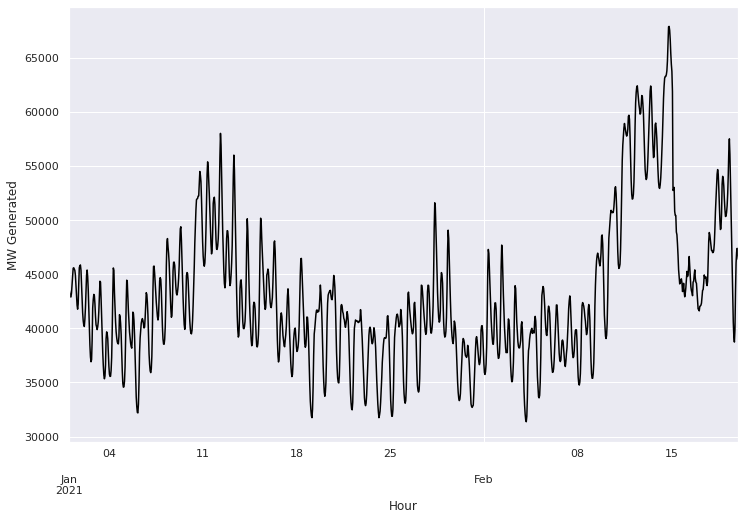

In [9]:
subset.T.sum().plot(figsize=(12, 8), xlabel='Hour', ylabel='MW Generated', 
                    color='#000000');

Notice the sharp spike in production, starting around the 9th. That's to meet demand from the winter storm.

Let's break it out by generation source:

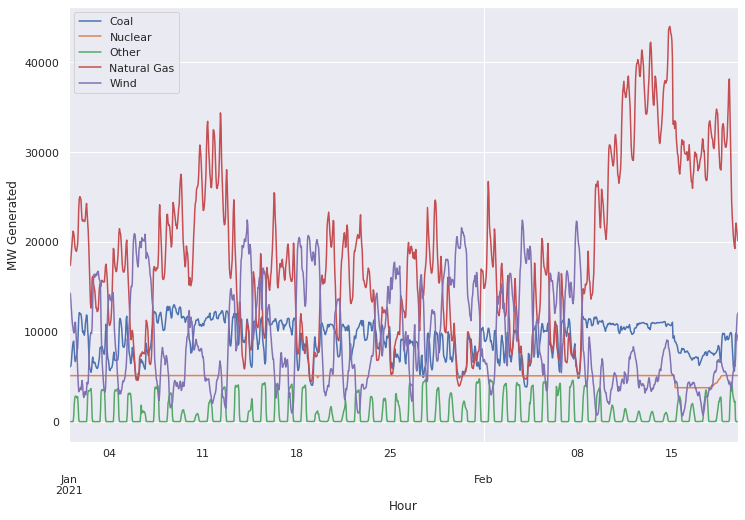

In [10]:
subset.plot(figsize=(12, 8), xlabel='Hour', ylabel='MW Generated');

Notice a few things:


1.   Demand really started spiking around February 9 to meet load. 60+ GW is a lot for any season, but especially winter.
2.   Around February 9, a very sizable chunk of wind power dropped off the grid.
3.   Around February 15, a very sizable chunk of all power sources dropped off the grid.



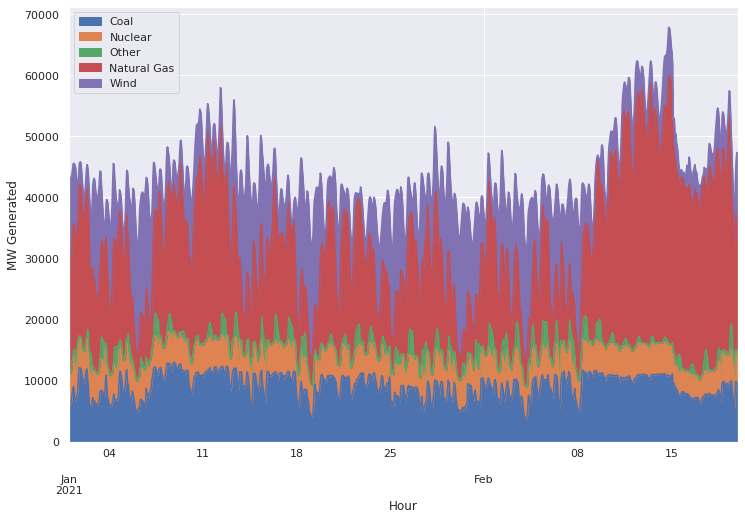

In [11]:
subset.plot.area(figsize=(12, 8), xlabel='Hour', ylabel='MW Generated');

Of the February 15 outages, it looks like it was evenly split throughout generation sources. It looks like almost all generation failed in equal measure, which is even clearer if we look at the relative energy mix. The relative share of each power source (except wind) stays constant:

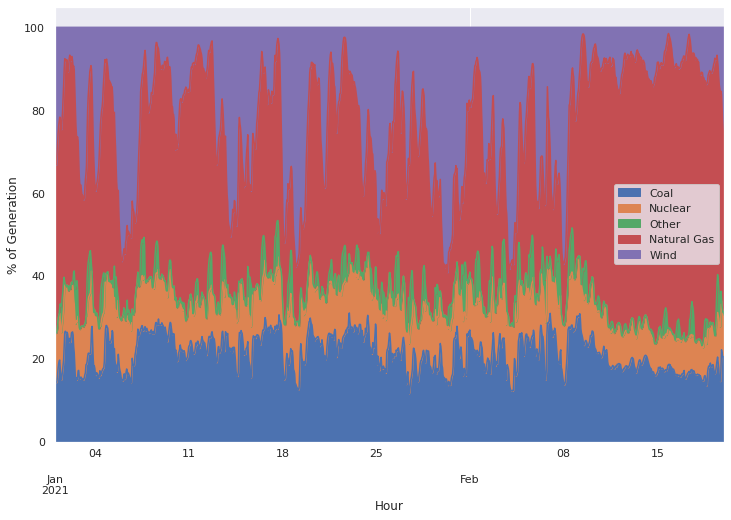

In [12]:
subset.divide(subset.T.sum(), axis=0).multiply(100).plot.area(
    figsize=(12, 8), xlabel='Hour', ylabel='% of Generation'
  );

As an aside, it doesn't look like gas did too badly here. Yes, there are reports of gas infrastructure freezing and gas shortages (prices were sky-high, strongly bolstering the shortages theory), and yes gas did lose a lot in absolute terms because it was shouldering most of the load, but gas _as a share of generation_ stayed flat throughout the whole crisis. So I don't think it's fair to pin this primarily on the gas infrastructure.

So what about the February 9 outages? That was mostly wind. Does that mean wind is to blame? If we had that generation, we'd be okay right?

No. Here's the dirty little secret about wind: Wind is so unreliable that it basically doesn't constitute a separate power source at all. Here's wind generation over the past month or so under normal conditions

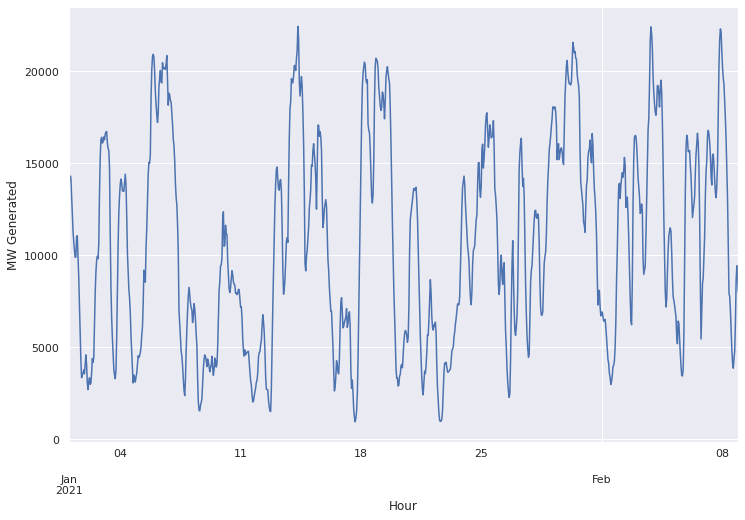

In [13]:
subset[subset.index.map(lambda x: x.date() <= date(2021, 2, 8))]['Wind'].plot(figsize=(12, 8), xlabel='Hour', ylabel='MW Generated');

It's all over the place. Yes, wind would "reliably" (about 75% of the time) deliver 5.7+ GW  But it even under normal conditions, it ranged from a whopping 22.4 GW to a measly 1.0 GW.

In [14]:
subset[subset.index.map(lambda x: x.date() <= date(2021, 2, 8))]['Wind'].describe()

count      936.000000
mean     10697.915598
std       5591.725396
min        953.000000
25%       5728.750000
50%      10297.500000
75%      15283.250000
max      22440.000000
Name: Wind, dtype: float64

Instead, wind power is probably better thought of as a gas-wind pairing.

To explain: Intermittent generation and AC voltages go together like oil and vinegar. The entire electric grid operates on the principle of very precisely calibrated stability. The electrons-in must equal the electrons-out pretty much all the time, so that the AC keeps oscilating at 60 hz, plus or minus basically nothing. Any sudden surges or drops and everything collapses. But wind is extremely intermittent, so in order to maintain a stable electric grid, we need to have on-demand generation ready to stabilize the grid when the wind stops blowing.

Enter natural gas: for various technical reasons, it is much easier/more economical to use natural gas plants to supply power on very short notice. These "peaking" units stabilize the intermittent generation from wind power. You can see this by looking at the combined generation from wind and gas during normal operations.

Combined, they make up about 25 GW of generation, but at any given moment one or the other is doing most of the work:

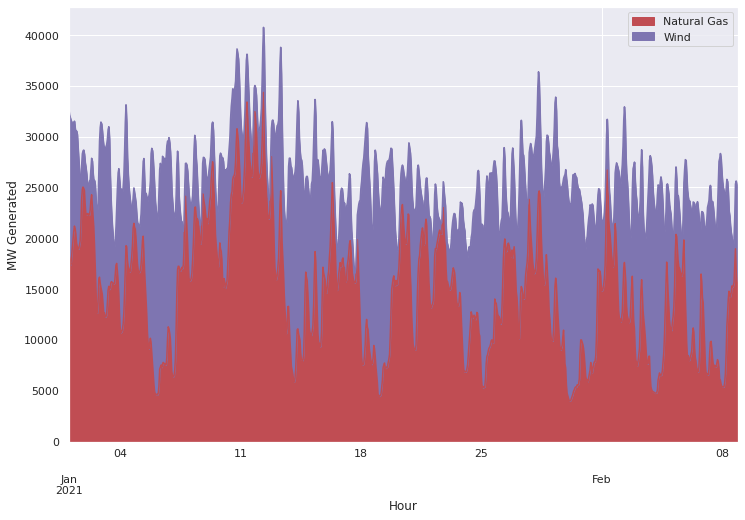

In [15]:
subset[subset.index.map(lambda x: x.date() <= date(2021, 2, 8))][['Natural Gas', 'Wind']].plot.area(
    figsize=(12, 8), xlabel='Hour', ylabel='MW Generated', 
    color=['#c04d53', '#7e75b1']
);

Even under normal operating conditions, wind and gas are extremely strongly negatively correlated:

In [16]:
subset[subset.index.map(lambda x: x.date() <= date(2021, 2, 8))][['Natural Gas', 'Wind']].corr()

,Natural Gas,Wind
Natural Gas,1.000000,-0.791056
Wind,-0.791056,1.000000


Basically, wind is a "nice to have" not a "must have." If all the wind drops off the grid (as it does pretty frequently), its complementary gas generation just steps up to pick up the slack.

So rather than even thinking about wind generation as a stand-alone resource, from a reliabilty standpoint it's better to think of wind-gas... a combined energy source that produces clean, cheap wind energy when possible but otherwise produces gas energy.

The only real question is what percentage of the total wind-gas generation is being generated by wind:

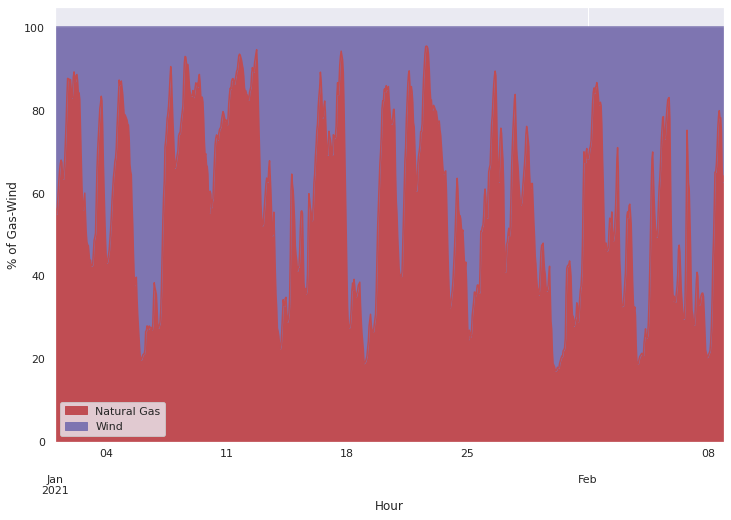

In [17]:
subset[subset.index.map(lambda x: x.date() <= date(2021, 2, 8))][['Natural Gas', 'Wind']].divide(
    subset[subset.index.map(lambda x: x.date() <= date(2021, 2, 8))][['Natural Gas', 'Wind']].T.sum(), axis=0
).multiply(100).plot.area(figsize=(12, 8), xlabel='Hour', ylabel='% of Gas-Wind', 
            color=['#c04d53', '#7e75b1']);

So when policy makers say that wind generators failed en masse, they're absolutely correct. However, what they're leaving out is that wind is so unreliable that it didn't make a difference anyway. The grid just assumes that the wind will drop off entirely anytime it feels like it, and so it basically has no part to play in resource adequacy.

This doesn't strike me as particularly flattering to wind, but it does mean that wind is not the appropriate scapegoat for reliability issues. Because, again, wind is not really a stand-alone resource; it's designed to run in tandem with (and be completely compensated for by) natural gas, which is exactly what we see happening when wind generation starts dropping off on February 9:

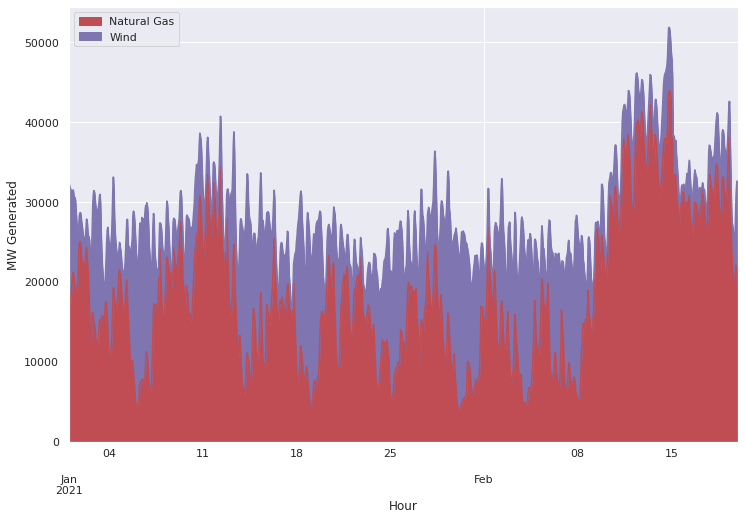

In [18]:
subset[['Natural Gas', 'Wind']].plot.area(
    figsize=(12, 8), xlabel='Hour', ylabel='MW Generated', 
    color=['#c04d53', '#7e75b1']
);

This point (that wind energy's unreliability is not to blame) becomes even stronger when we compare the EIA's generation data to ERCOT's outage data.

Here's ERCOT's outages over the past month. Notice a few things:

1.   We had about 15 GW of (what I assume were) planned outages already. That's not unusual, that's standard maintenance. I believe the bulk of maintenance outages are done in the spring and fall, but it isn't unusual to have some in the winter.
2.   There were two big unplanned/forced outage events. One was on February 9, when around 15 GW of renewable capacity went offline. The second was on February 15, when another 20 GW or so went offline (proportionally from renewables and thermal).

ERCOT only provides outage data for aggregated Intermittent and Non-Intermittent power (basically, renewables vs. thermal), but it's reasonable to assume that most of the renewable outages were wind (there isn't much solar capacity).



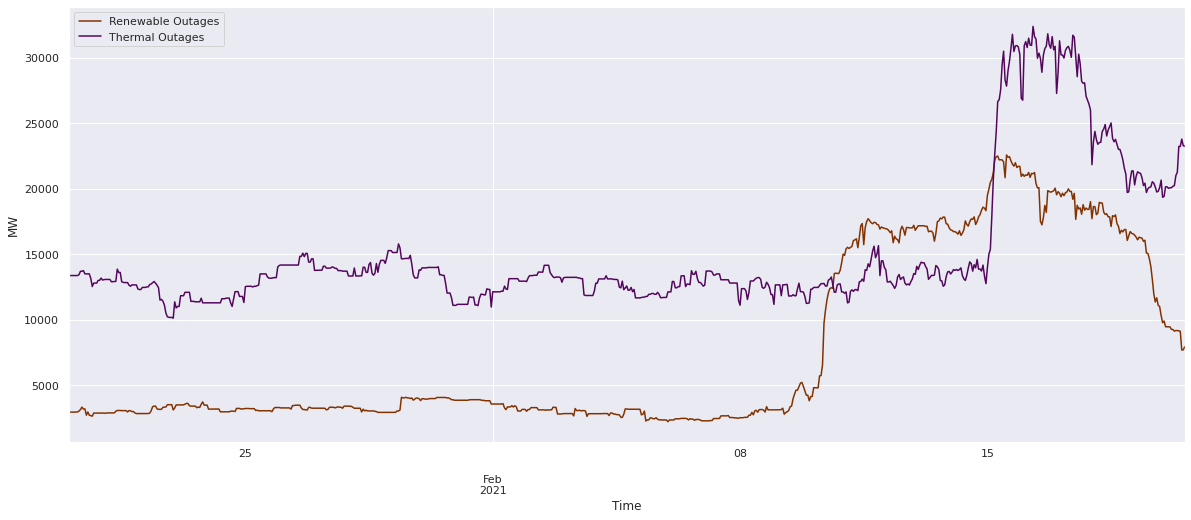

In [19]:
outages.plot(xlabel='Time', ylabel='MW', figsize=(20, 8), color=['#823200', '#53065C']);

Notice the gas generation vs. the thermal outages. Gas generation starts dropping off at exactly the same time as the thermal outages are reported. Obviously, the drop in generation is due to outages, likely relating to lack of winterization.

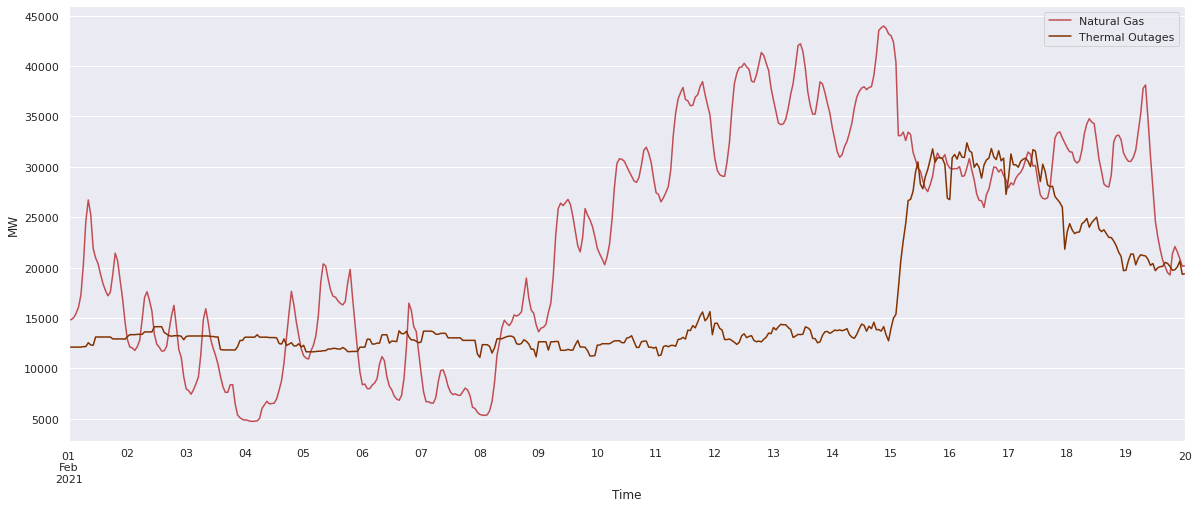

In [20]:
gas_vs_thermal = df[df.index.map(lambda x: x.date()) >= date(2021, 2, 1)].join(outages)[['Natural Gas', 'Thermal Outages']]
gas_vs_thermal.plot(figsize=(20, 8), color=['#c04d53', '#823200'],
                    xlabel='Time', ylabel='MW');

In [21]:
print('Correlation')
gas_vs_thermal.corr()

Correlation


,Natural Gas,Thermal Outages
Natural Gas,1.000000,0.359811
Thermal Outages,0.359811,1.000000


Same story for coal:

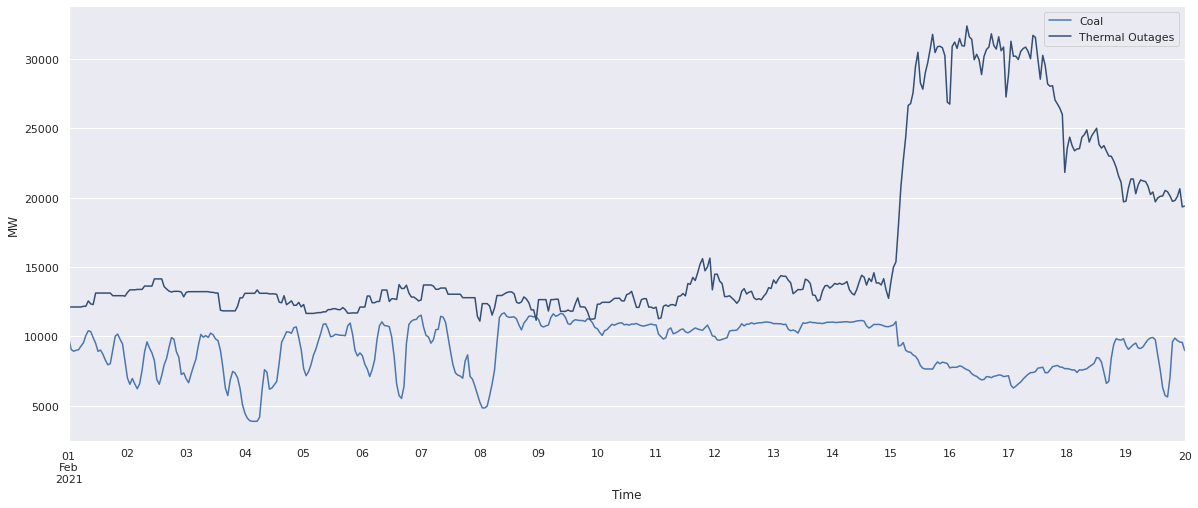

In [22]:
coal_vs_thermal = df[df.index.map(lambda x: x.date()) >= date(2021, 2, 1)].join(outages)[['Coal', 'Thermal Outages']]
coal_vs_thermal.plot(figsize=(20, 8), color=['#4a75ae', '#344F73'],
                    xlabel='Time', ylabel='MW');

In [23]:
print('Correlation')
coal_vs_thermal.corr()

Correlation


,Coal,Thermal Outages
Coal,1.000000,-0.422712
Thermal Outages,-0.422712,1.000000


Same story for nuclear:

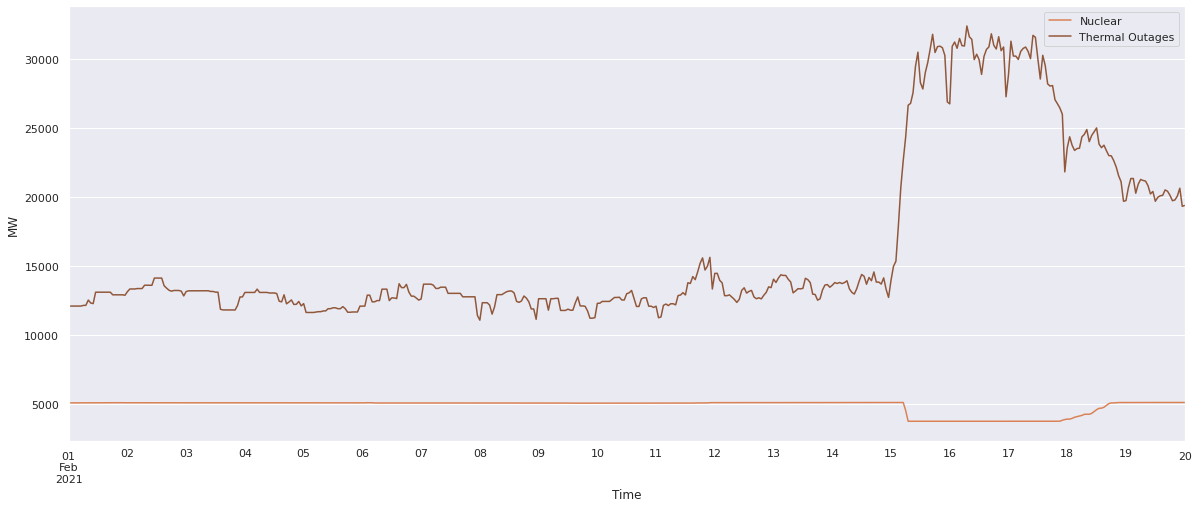

In [24]:
nuclear_vs_thermal = df[df.index.map(lambda x: x.date()) >= date(2021, 2, 1)].join(outages)[['Nuclear', 'Thermal Outages']]
nuclear_vs_thermal.plot(figsize=(20, 8), color=['#da8256', '#91573A'],
                    xlabel='Time', ylabel='MW');

In [25]:
print('Correlation')
nuclear_vs_thermal.corr()

Correlation


,Nuclear,Thermal Outages
Nuclear,1.000000,-0.917269
Thermal Outages,-0.917269,1.000000


Interesting aside, that's one of the Texas South Units (which are on the Gulf) going offline. Those are regulated by the Federal Nuclear Regulatory Commission. Further, it's pretty clear that the reactor went offline due to cold weather.

These two facts together strongly cut against any narrative that federal control is _ipso facto_ better than state control on the issue of winterization or reliability, or that greedy generators ignored winterization recommendations that a generator with more oversight would have followed. It's hard to get more regulated than a nuclear reactor, though I confess I'm not anything an expert on NRC regulations.

And of course the same story for wind. It's generation dropped at precisely the same time as and almost perfectly in step with the renewable outages:

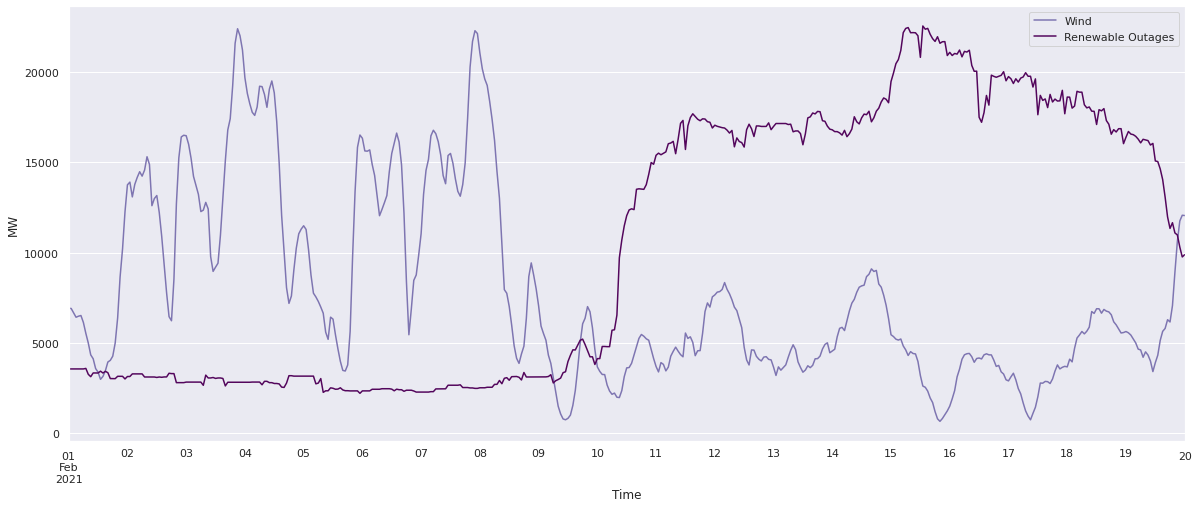

In [26]:
wind_vs_renewables = df[df.index.map(lambda x: x.date()) >= date(2021, 2, 1)].join(outages)[['Wind', 'Renewable Outages']]
wind_vs_renewables.plot(figsize=(20, 8), color=['#7e75b1', '#53065C'],
                        xlabel='Time', ylabel='MW');

This is a pretty strong correlation (stronger than any other correlation besides nuclear):

In [27]:
print('Correlation')
wind_vs_renewables.corr()

Correlation


,Wind,Renewable Outages
Wind,1.000000,-0.615281
Renewable Outages,-0.615281,1.000000


It might be tempting to say that this strong correlation means wind energy is more susceptible to cold than other power sources. That might actually be correct, except for one thing: all forms of energy generation can be winterized, including wind.

So rather than pinning the "blame" on wind qua wind, it might be better to better to pin the "blame" on winterization (across all power sources).

So pulling all of that together, here's the summary:

1.   Yes, we lost a lot of wind generation
2.   Yes, wind is very unreliable.
3.   Strangely, those two facts are not correlated here.
4.   Wind generation fell because of the same generation outages that affected every major power source roughly in proportion to their output.
5.   "Luckily" wind is so unreliable that no one counts on it.
6.   Ergo the wind outages weren't to "blame"

Basically, "Wind energy didn't perform very well, but no one expected it to, so no harm, no foul." This argument is valid and sound, as far as it goes, but not a particularly strong defense of wind. However, it does mean that we need to look further than "renewables" to properly explain last week's outages.


